### Stuart-Landau model

In [1]:
import itertools
from functools import partial

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from frites.utils import parallel_func
from hoi.core import get_mi
from tqdm import tqdm

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

#### Model definition

In [3]:
def randn(mu: float = 0, sig: float = 0, size: tuple = (1,), seed: int = 0):

    return jax.random.normal(jax.random.key(seed), shape=size)


def _ode(Z: np.complex128, a: float, w: float, Iext: float):
    return Z * (a + 1j * w - np.abs(Z * Z)) + Iext


def simulate(
    f: float,
    a: float,
    beta: float,
    T: np.ndarray = np.arange(-0.5, 1, 1e-4),
    Iext: np.ndarray = None,
    seed: int = 0,
    decim: int = 1,
    mode: str = "amp",
):

    assert mode in ["amp", "phase", "both"]

    gain = 0
    phi = 0
    offset = 1

    if mode == "amp":
        gain = 1
        offset = 0
    elif mode == "phase":
        gain = 1
        phi = np.pi / 2
        offset = 0

    # Model patameters
    w_0 = 2 * np.pi * f

    # Simulation parameters
    dt = np.diff(T)[0]

    if Iext is None:
        Iext = np.zeros_like(T)

    Z = dt + dt * 1j

    eta_1 = randn(seed=seed, size=(len(T),))
    eta_2 = randn(seed=seed + 1000, size=(len(T),))
    eta = np.sqrt(dt) * beta * (eta_1 + 1j * eta_2)

    def _loop(carry, t):
        Z, eta, Iext = carry

        exp_phi = gain * np.exp(1j * (np.angle(Z) + phi)) + offset

        Z = Z + dt * _ode(Z, a, w_0, Iext[t] * exp_phi) + eta[t]

        carry = Z, eta, Iext

        return carry, Z

    _, Z = jax.lax.scan(_loop, (Z, eta, Iext), np.arange(len(T)))

    return Z[..., ::decim]

#### Bifurcation diagram

In [4]:
a_vec = np.linspace(-5, 5, 100)

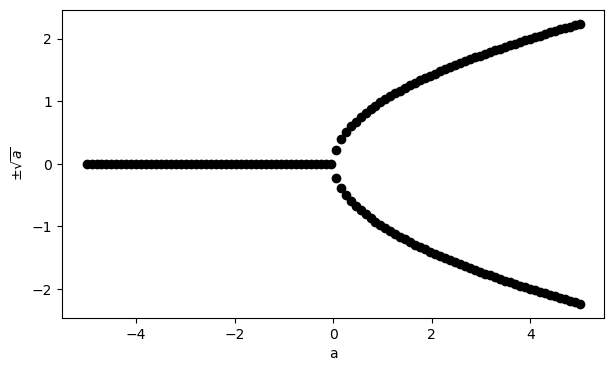

In [5]:
plt.figure(figsize=(7, 4))
for a in a_vec:

    if a <= 0:
        plt.scatter(a, 0, c="k")
    else:
        fp = np.sqrt(a)
        plt.scatter(a, -fp, c="k")
        plt.scatter(a, fp, c="k")
plt.xlabel("a")
plt.ylabel(r"$\pm \sqrt{a}$");

#### Phase diagrams without noise

In [6]:
a_vec = np.array([-5, 0, 5])

In [7]:
Z = [simulate(40, a, 0, seed=0) for a in a_vec]

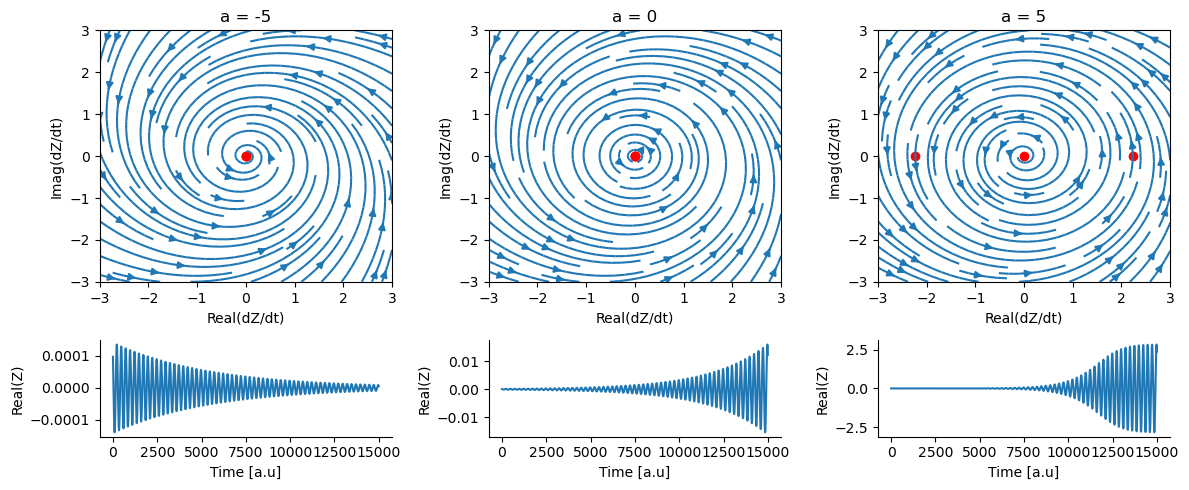

In [8]:
fig, axs = plt.subplot_mosaic([[0, 2, 4], [0, 2, 4], [1, 3, 5]], figsize=(12, 5))

pos = 0
for i, Z_ in enumerate(Z):

    fp = np.sqrt(a_vec[i] + 1j * 0)
    if a_vec[i] < 0:
        fp = 0 + 1j * 0

    fixed_points = np.array([[0.0, 0.0], [fp.real, fp.imag], [-fp.real, -fp.imag]])

    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    dZdt = _ode(X + 1j * Y, a_vec[i], 40, 0)

    Xdot = dZdt.real
    Ydot = dZdt.imag

    plt.sca(axs[pos])
    axs[pos].streamplot(
        numpy.array(X), numpy.array(Y), numpy.array(Xdot), numpy.array(Ydot)
    )
    axs[pos].scatter(*fixed_points.T, color="r")
    plt.title(f"a = {a_vec[i]}")
    plt.xlabel("Real(dZ/dt)")
    plt.ylabel("Imag(dZ/dt)")

    pos = pos + 1
    plt.sca(axs[pos])
    axs[pos].plot(Z_.real)
    axs[pos].spines["top"].set_visible(False)
    axs[pos].spines["right"].set_visible(False)
    plt.xlabel("Time [a.u]")
    plt.ylabel("Real(Z)")
    pos = pos + 1

plt.tight_layout()

#### Phase diagrams with noise

In [9]:
Z_noise = [simulate(40, a, 1e-4, seed=0) for a in a_vec]

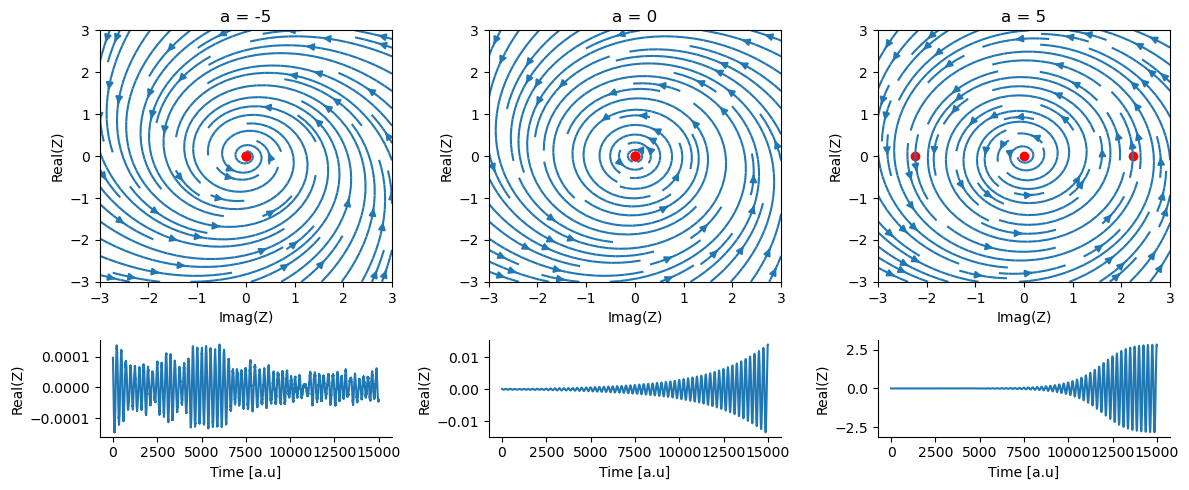

In [10]:
fig, axs = plt.subplot_mosaic([[0, 2, 4], [0, 2, 4], [1, 3, 5]], figsize=(12, 5))

pos = 0
for i, Z_ in enumerate(Z_noise):

    fp = np.sqrt(a_vec[i] + 1j * 0)
    if a_vec[i] < 0:
        fp = 0 + 1j * 0

    fixed_points = np.array([[0.0, 0.0], [fp.real, fp.imag], [-fp.real, -fp.imag]])

    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    dZdt = _ode(X + 1j * Y, a_vec[i], 40, 0)

    Xdot = dZdt.real
    Ydot = dZdt.imag

    plt.sca(axs[pos])
    axs[pos].streamplot(
        numpy.array(X), numpy.array(Y), numpy.array(Xdot), numpy.array(Ydot)
    )
    axs[pos].scatter(*fixed_points.T, color="r")
    plt.title(f"a = {a_vec[i]}")
    plt.xlabel("Imag(Z)")
    plt.ylabel("Real(Z)")

    pos = pos + 1
    plt.sca(axs[pos])
    axs[pos].plot(Z_.real)
    axs[pos].spines["top"].set_visible(False)
    axs[pos].spines["right"].set_visible(False)
    plt.xlabel("Time [a.u]")
    plt.ylabel("Real(Z)")
    pos = pos + 1

plt.tight_layout()

#### Input to phase or amplitude

In [151]:
fsamp = 1e-4
T = np.arange(-5, 5, fsamp)
Iext = np.zeros_like(T)
Iext = Iext.at[(T >= 0) & (T < 0.1)].set(50)

Z_amp = simulate(
    40,
    -5,
    0.1,
    T,
    Iext,
    0,
    1,
    "amp",
)


Z_phi = simulate(
    40,
    -5,
    0.1,
    T,
    Iext,
    0,
    1,
    "phase",
)

Z_both = simulate(
    40,
    -5,
    0.1,
    T,
    Iext,
    0,
    1,
    "both",
)

In [152]:
T_ = T[(T >= -0.2) & (T < 0.5)]
Z_amp = Z_amp[(T >= -0.2) & (T < 0.5)]
Z_phi = Z_phi[(T >= -0.2) & (T < 0.5)]
Z_both = Z_both[(T >= -0.2) & (T < 0.5)]

In [153]:
onset = np.argmin(np.abs(T_))

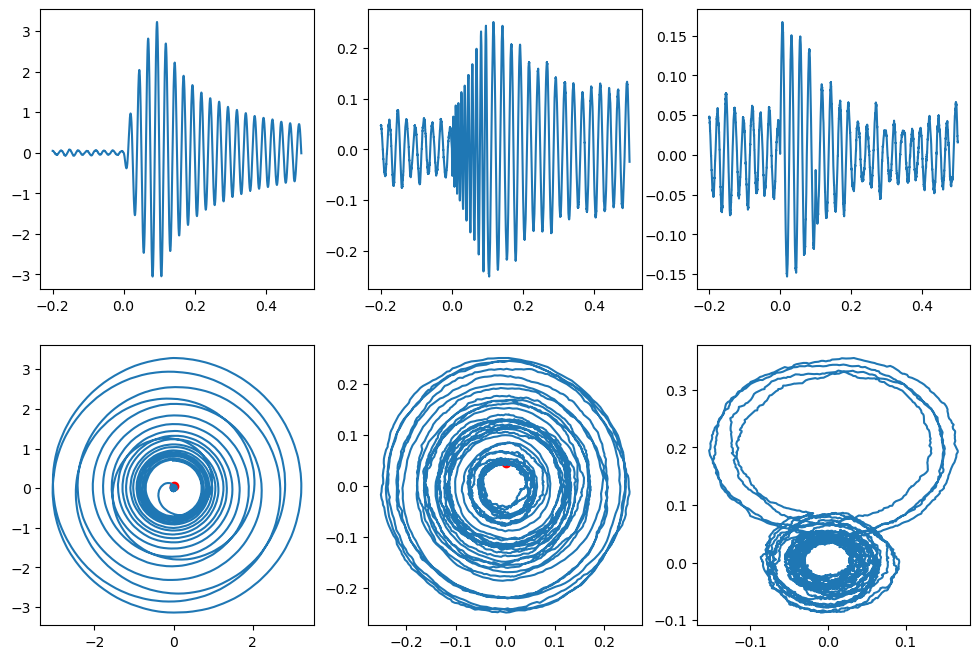

In [154]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.plot(T_, Z_amp.real)
plt.subplot(232)
plt.plot(T_, Z_phi.real)
plt.subplot(233)
plt.plot(T_, Z_both.real)
plt.subplot(234)
plt.plot(Z_amp.real, Z_amp.imag)
plt.scatter(Z_phi.real[onset], Z_phi.imag[onset], c="r")
plt.subplot(235)
plt.plot(Z_phi.real, Z_phi.imag)
plt.scatter(Z_phi.real[onset], Z_phi.imag[onset], c="r")
plt.subplot(236)
plt.plot(Z_both.real, Z_both.imag)
plt.scatter(Z_both.real[onset], Z_both.imag[onset], c="r")

#### Stimulus encoding

In [11]:
simulate_jax = jax.vmap(simulate, in_axes=(None, None, None, None, 0, 0, None, None))

In [12]:
a_vec = np.linspace(-15, 5, 60)
beta_vec = np.geomspace(1e-4, 1e-3, 60)

In [13]:
T = np.arange(-0.5, 1, 1e-4)
I = np.zeros((100, T.shape[0]))
for i in range(100):
    I = I.at[i, (T >= 0) * (T <= 0.2)].set(1e-4 * i)

In [14]:
seeds = np.arange(100, dtype=int)

In [15]:
out1 = simulate_jax(40, -5, 1e-3, T, I, seeds, 1, "amp")
out2 = simulate_jax(40, 0, 1e-3, T, I, seeds, 1, "amp")
out3 = simulate_jax(40, 5, 1e-3, T, I, seeds, 1, "amp")

Text(0.5, 0, 'time [s]')

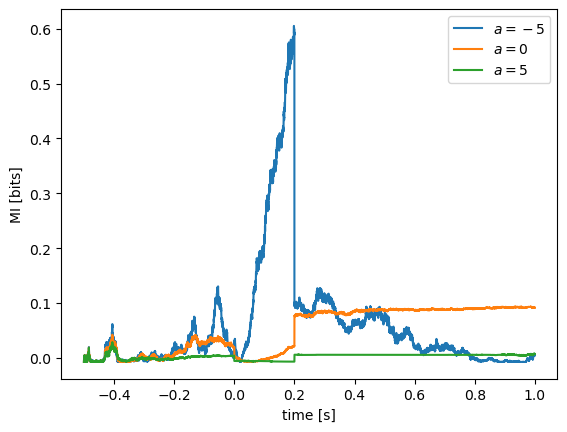

In [16]:
plt.plot(T, gcmi_nd_cc(numpy.asarray(out1 * np.conj(out1)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out2 * np.conj(out2)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out3 * np.conj(out3)), numpy.asarray(I), traxis=0))

plt.legend([r"$a = -5$", r"$a = 0$", r"$a = 5$"])

plt.ylabel("MI [bits]")
plt.xlabel("time [s]")

In [17]:
grid = np.array(np.meshgrid(a_vec, beta_vec)).T.reshape(-1, 2)
grid.shape

(3600, 2)

In [18]:
simulate_jax_2 = jax.vmap(
    simulate_jax, in_axes=(None, 0, 0, None, None, None, None, None)
)

In [19]:
blocks = np.array_split(np.arange(grid.shape[0]), 600)

In [20]:
grid.shape

(3600, 2)

In [21]:
out = []
for block in tqdm(blocks):
    out += [simulate_jax_2(40, grid[block, 0], grid[block, 1], T, I, seeds, 15, "amp")]

100%|██████████████████████████████████████████████████████| 600/600 [03:13<00:00,  3.09it/s]


In [22]:
out = numpy.concatenate(out, axis=0)

In [23]:
MIs = []
for _out in tqdm(out):
    try:
        MIs += [
            gcmi_nd_cc(
                numpy.asarray(_out * np.conj(_out)),
                numpy.asarray(I[..., ::15]),
                traxis=0,
            ).max()
        ]
    except:
        MIs += [0]

100%|████████████████████████████████████████████████████| 3600/3600 [01:53<00:00, 31.67it/s]


In [24]:
MIs_xr = xr.DataArray(
    numpy.stack(MIs).reshape(a_vec.shape[0], beta_vec.shape[0]),
    dims=("a", "beta"),
    coords=(a_vec, beta_vec),
    name="MI [bits]",
)

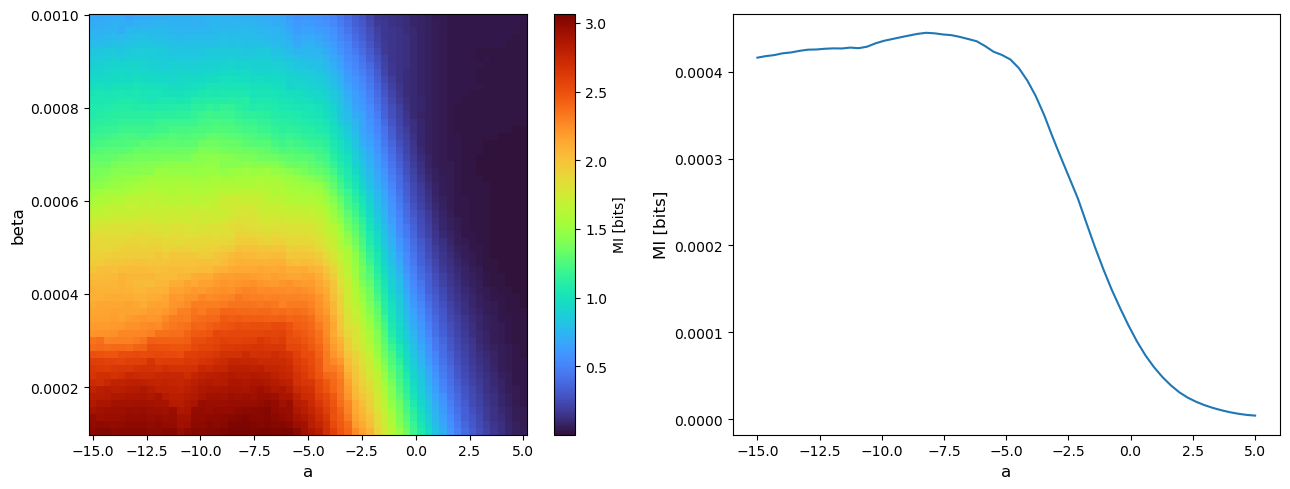

In [25]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
MIs_xr.T.plot.imshow(cmap="turbo")
plt.xlabel("a", fontsize=12)
plt.ylabel("beta", fontsize=12)

plt.subplot(122)
(MIs_xr * numpy.diff(beta_vec)[0]).sum("beta").plot()
plt.xlabel("a", fontsize=12)
plt.ylabel("MI [bits]", fontsize=12)

plt.tight_layout()

#### Two-nodes feed-forward connection (no-delays)

In [11]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/StuartLandauWBM/")

In [12]:
from src.models import simulate

In [13]:
Nareas = 2  # Number of areas
fsamp = 1 / 1e-4
time = np.arange(-0.5, 5, 1 / fsamp)
beta = 1e-3
Npoints = len(time)

f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

g = 5
C = np.array([[0, 0], [1, 0]])

In [14]:
T = np.linspace(-0.5, 1, Npoints)
I = np.zeros((100, 2, T.shape[0]))
for i in range(100):
    I = I.at[i, 0, (T >= 0) * (T <= 0.2)].set(1e-4 * i)

In [15]:
simulate_jax = jax.vmap(
    simulate, in_axes=(None, None, None, None, None, None, None, 0, 0, None, None)
)

In [16]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z = (
    simulate_jax(C, g, f, np.array([-5, 0]), fsamp, beta, Npoints, I, seeds, "gpu", 15)
    .squeeze()
    .transpose(0, 2, 1)
)

Text(0.5, 0, 'time [s]')

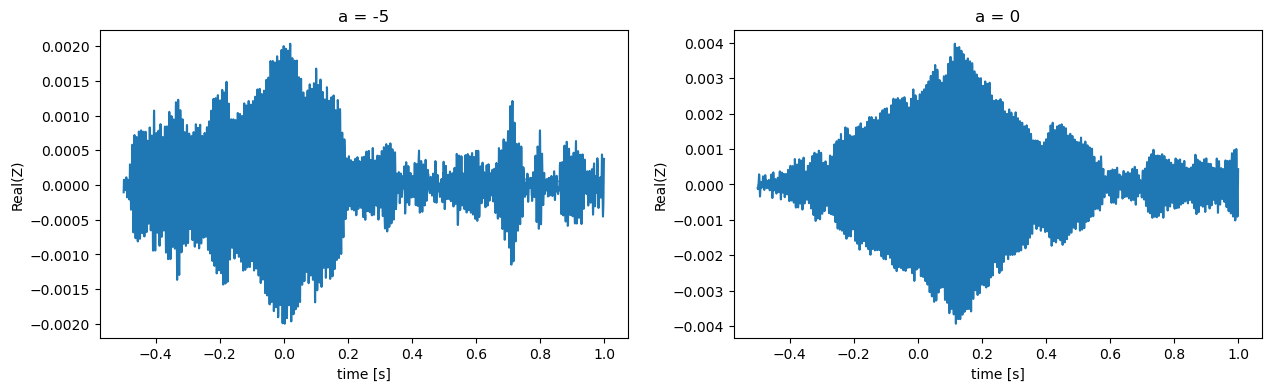

In [17]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[0, 0].real)
plt.title("a = -5")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")
plt.subplot(122)
plt.plot(T[::15], Z[0, 1].real)
plt.title("a = 0")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")

Text(0.5, 0, 'time [s]')

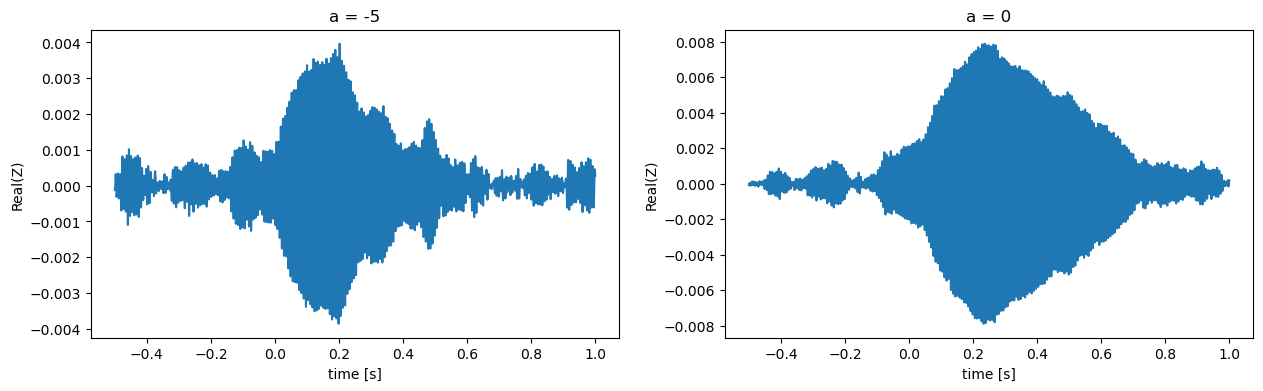

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[-1, 0].real)
plt.title("a = -5")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")
plt.subplot(122)
plt.plot(T[::15], Z[-1, 1].real)
plt.title("a = 0")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")

In [19]:
simulate_jax_2 = jax.vmap(
    simulate_jax,
    in_axes=(None, 0, None, None, None, None, None, None, None, None, None),
)

In [20]:
g_vec = np.linspace(0, 10, 60)

In [21]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z_homogeneous = (
    numpy.asarray(
        simulate_jax_2(
            C, g_vec, f, np.array([-5, -5]), fsamp, beta, Npoints, I, seeds, "cpu", 15
        )
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z_heterogeneous = (
    numpy.asarray(
        simulate_jax_2(
            C, g_vec, f, np.array([-5, 0]), fsamp, beta, Npoints, I, seeds, "cpu", 15
        )
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

In [22]:
mi_homogeneous = []

for i in tqdm(range(60)):
    mi_homogeneous += [
        gccmi_nd_ccc(
            x=numpy.abs(Z_homogeneous[i, :, 0]),
            y=numpy.abs(Z_homogeneous[i, :, 1]),
            z=numpy.array(I[:, 0, ::15]),
            traxis=0,
        )
    ]

mi_homogeneous = np.stack(mi_homogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.53it/s]


In [23]:
mi_heterogeneous = []

for i in tqdm(range(60)):
    mi_heterogeneous += [
        gccmi_nd_ccc(
            x=numpy.abs(Z_heterogeneous[i, :, 0]),
            y=numpy.abs(Z_heterogeneous[i, :, 1]),
            z=numpy.array(I[:, 0, ::15]),
            traxis=0,
        )
    ]

mi_heterogeneous = np.stack(mi_heterogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.69it/s]


(-0.1, 2.0)

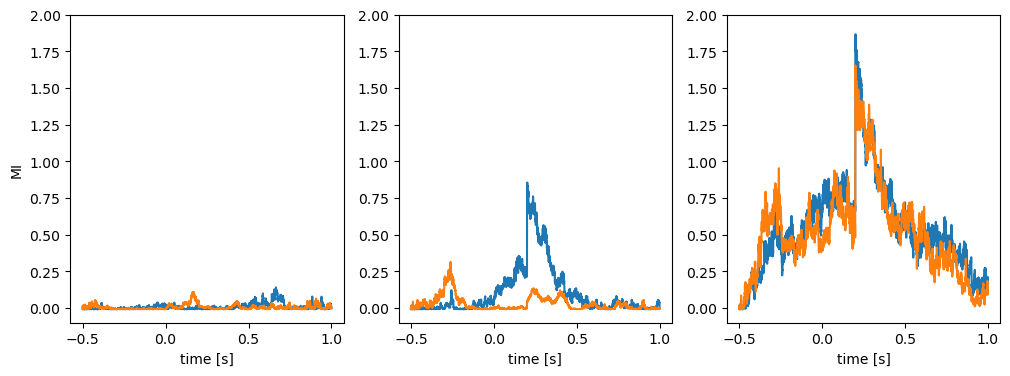

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot((131))
plt.plot(T[::15], mi_homogeneous[0])
plt.plot(T[::15], mi_heterogeneous[0])
plt.ylabel("MI")
plt.xlabel("time [s]")
plt.ylim(-0.1, 2)
plt.subplot((132))
plt.plot(T[::15], mi_homogeneous[16])
plt.plot(T[::15], mi_heterogeneous[16])
plt.xlabel("time [s]")
plt.ylim(-0.1, 2)
plt.subplot((133))
plt.plot(T[::15], mi_homogeneous[-1])
plt.plot(T[::15], mi_heterogeneous[-1])
plt.xlabel("time [s]")
plt.ylim(-0.1, 2)

Text(0.5, 0, 'g')

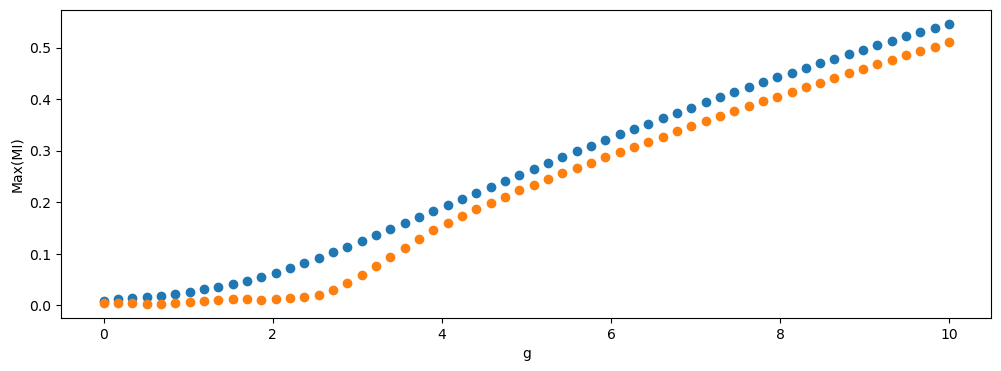

In [26]:
plt.figure(figsize=(12, 4))

plt.plot(g_vec, mi_homogeneous.mean(1), "o")
plt.plot(g_vec, mi_heterogeneous.mean(1), "o")
plt.ylabel("Max(MI)")
plt.xlabel("g")

In [93]:
g_vec = np.linspace(0, 10, 30)
a_vec = np.linspace(-5, 5, 30)

grid = np.array(np.meshgrid(np.array([0]), a_vec, g_vec)).T.reshape(-1, 3)
grid.shape

(900, 3)

In [94]:
blocks = np.array_split(np.arange(grid.shape[0]), 10)
blocks[0].shape

(90,)

In [95]:
simulate_jax_3 = jax.vmap(
    simulate_jax,
    in_axes=(None, 0, None, 0, None, None, None, None, None, None, None),
)

In [96]:
out = []
for block in tqdm(blocks):
    out += [
        simulate_jax_3(
            C,
            grid[block][:, 2],
            f,
            grid[block][:, :2],
            fsamp,
            beta,
            Npoints,
            I,
            seeds,
            "cpu",
            15,
        )
    ]

100%|███████████████████████████████████████████████████████| 10/10 [30:51<00:00, 185.11s/it]


In [97]:
result = numpy.concatenate(out).squeeze()
result = result.transpose(0, 1, 3, 2)

In [114]:
mi = []

for i in tqdm(range(grid.shape[0])):
    try:
        mi += [
            gccmi_nd_ccc(
                x=numpy.abs(result[i, :, 0]),
                y=numpy.abs(result[i, :, 1]),
                z=numpy.array(I[:, 0, ::15]),
                traxis=0,
            )
        ]
    except:
        mi += [numpy.zeros_like(T[::15])]

mi = np.stack(mi)

100%|██████████████████████████████████████████████████████| 900/900 [02:24<00:00,  6.22it/s]


In [115]:
mi.shape

(900, 3667)

In [116]:
mi_ = xr.DataArray(
    mi.reshape(a_vec.shape[0], g_vec.shape[0], -1).mean(-1),
    dims=("a_diff", "g"),
    coords=(a_vec, g_vec),
)

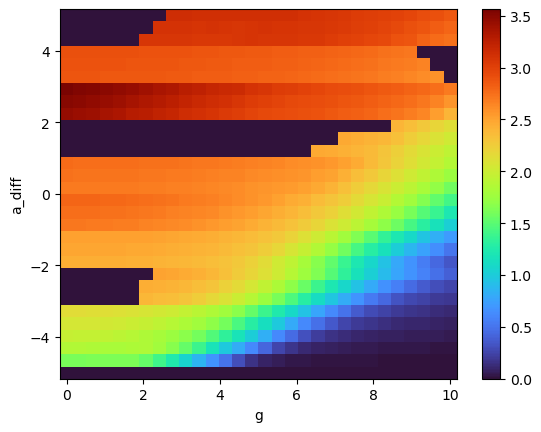

In [118]:
mi_.plot.imshow( origin="lower", vmin=0, cmap="turbo")

In [109]:
mi

<xarray.DataArray (a_diff: 30, g: 30)> Size: 7kB
array([[ 0.0832465 ,  0.08124108,  0.08396127,  0.08227641,  0.10234611,
         0.10256807,  0.11692212,  0.12556694,  0.10988721,  0.09132284,
         0.07472375,  0.07029059,  0.0898201 ,  0.10439772,  0.09586785,
         0.09098688,  0.09506303,  0.10510864,  0.10251033,  0.09863946,
         0.09848307,  0.10505416,  0.10437646,  0.11469827,  0.11050422,
         0.11014   ,  0.10561918,  0.10569847,  0.10740535,  0.10913433],
       [ 6.54862009,  6.67668772,  6.71181345,  6.83207106,  6.84077997,
         6.5985736 ,  6.1387478 ,  5.32645737,  4.64733401,  3.77702106,
         2.7656084 ,  2.28326231,  1.6209894 ,  1.02928244,  0.57758221,
         0.33248353,  0.22121872,  0.16357763,  0.13104034,  0.09873314,
         0.08596534,  0.07461734,  0.07361545,  0.07478939,  0.07349969,
         0.07201212,  0.06787757,  0.06596506,  0.06297359,  0.06157626],
       [ 7.43172311,  7.55666763,  7.55666763,  7.25768129,  7.54440857,
         7.54426946,  7.14112714,  6.43770782,  5.82902337,  5.27257196,
         4.72149812,  4.01220652,  2.92715823,  2.52942053,  1.9913765 ,
         1.45288158,  0.91823173,  0.59878112,  0.40797186,  0.3025077 ,
         0.25104263,  0.20842453,  0.16704635,  0.14610264,  0.12970342,
         0.11826358,  0.1103552 ,  0.10203856,  0.09447046,  0.08527892],
       [ 6.35488179,  6.35488179,  6.23390403,  6.18079276,  6.40509276,
         6.103778  ,  5.97946264,  5.53013786,  5.36629031,  5.58941237,
...
         8.0397383 ,  8.0397383 ,  8.0397383 ,  8.0397383 ,  8.0397383 ,
         8.0397383 ,  8.0397383 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43846003, 26.43846003, 26.43846003, 26.43846003, 26.43846003],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43846003, 26.43846003, 26.43846003, 26.43846003],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 26.43879332, 26.43879332,
        26.43879332, 26.43879332, 26.43879332, 26.43879332, 26.43879332,
        26.43879332, 26.43879332, 26.43879332, 26.43879332, 26.43856962,
        26.43856962, 26.43856962, 26.43856962, 26.43856962, 26.43856962,
        26.43856962, 26.43856962, 26.43846003, 26.43846003, 26.43846003]])
Coordinates:
  * a_diff   (a_diff) float64 240B -5.0 -4.655 -4.31 -3.966 ... 4.31 4.655 5.0
  * g        (g) float64 240B 0.0 0.3448 0.6897 1.034 ... 8.966 9.31 9.655 10.0